In [2]:
from heart_model import VAE, load_model
from heart_display import load_images
from heart_dataset import HeartDataset
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
model = VAE(latent_dim=8)

load_model(model, 'models/best_hyperparameters_model.pth')

Model loaded from models/best_hyperparameters_model.pth


In [4]:
train_images, train_names = load_images('../data/all_patient_images')
test_images, test_names = load_images('../data/all_patient_images_test')

In [5]:
train_dataset = HeartDataset(train_images)
test_dataset = HeartDataset(test_images)

In [6]:
def get_codes(model, dataset, names, add_label=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    codes = []
    labels = []
    with torch.no_grad():
        for idx in range(len(dataset)):
            oh_image = dataset[idx].unsqueeze(0)
            oh_image = oh_image.to(device)
            code = model.encoder(oh_image)[0].squeeze(0) # Discard logvar
            codes.append(code)
            path_split = max(names[idx].rfind('/'), names[idx].rfind('\\'))
            name = names[idx][path_split + 1 : names[idx].find('.nii.gz')]
            label = name.split('_')
            if add_label:
                label.append(add_label)
            labels.append(label)
    
    codes = torch.stack(codes).cpu().numpy()
    labels = np.array(labels)
    return codes, labels


In [7]:
train_codes, train_labels = get_codes(model, train_dataset, train_names, add_label='train')
test_codes, test_labels = get_codes(model, test_dataset, test_names, add_label='test')

In [8]:
codes = np.concatenate([train_codes, test_codes])
labels = np.concatenate([train_labels, test_labels])
split = len(train_codes)

In [9]:
df = pd.DataFrame({
    'Patient number' : labels[:, 0].astype(int),
    'Group' : labels[:, 1],
    'Height' : labels[:, 2].astype(int),
    'Weight' : labels[:, 3].astype(int),
    'ED/ES' : labels[:, 4],
    'Slice index' : labels[:, 5].astype(int),
    'Slice height': pd.to_numeric(pd.Series(labels[:, 6]), errors='coerce').fillna(-100).to_numpy()/100,
    'Empty slice': labels[:, 6] == 'NA',
    'Train/test': labels[:, 7]
})

In [10]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(codes)

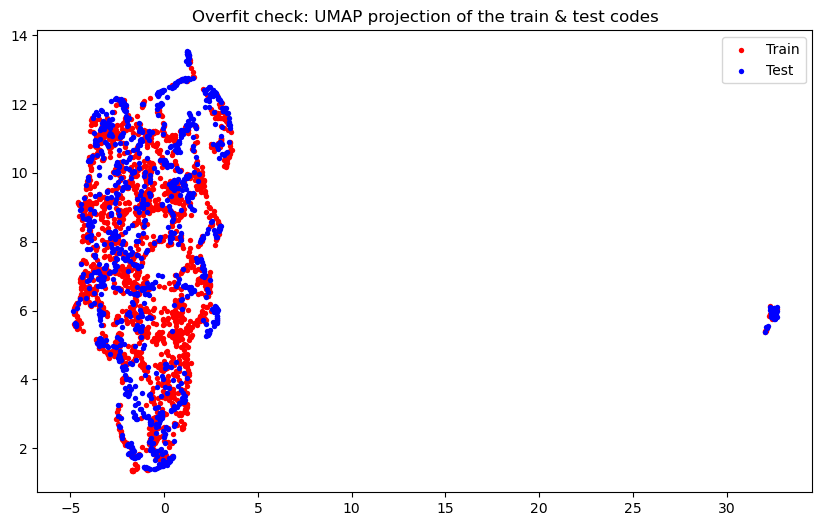

In [10]:
fig, ax = plt.subplots(figsize = (10, 6))

x = embeddings[:, 0]
y = embeddings[:, 1]
ax.scatter(x[:split], y[:split], c='red', label='Train', s=15, edgecolors='black', linewidths=0., alpha=1)
ax.scatter(x[split:], y[split:], c='blue', label='Test', s=15, edgecolors='black', linewidths=0., alpha=1)

ax.legend()
ax.set_title('Overfit check: UMAP projection of the train & test codes')
#plt.savefig('pngs/umap_overfit_check.png')
plt.show()

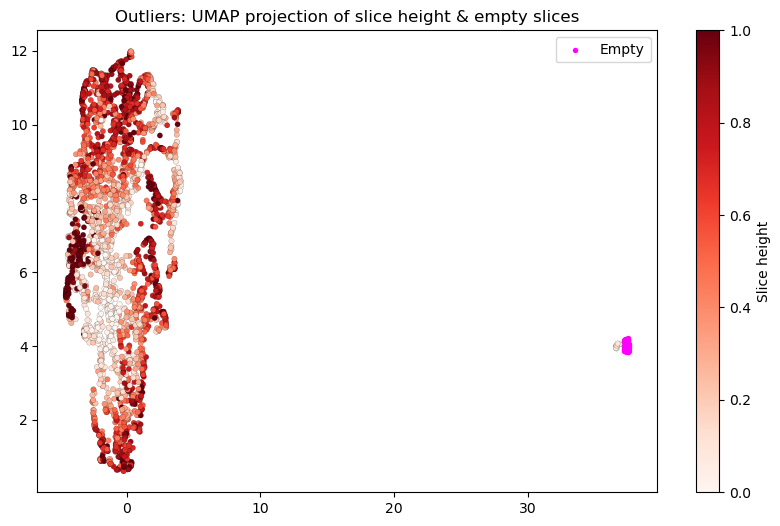

In [12]:
fig, ax = plt.subplots(figsize = (10, 6))

mask = df['Empty slice']

x = embeddings[:, 0]
y = embeddings[:, 1]

sc_empty = ax.scatter(x[mask], y[mask], c='magenta', label='Empty', s=15, edgecolors='black', linewidths=0., alpha=1)
sc_not_empty = ax.scatter(x[~mask], y[~mask], c=df['Slice height'][~mask], cmap='Reds', label='Not empty', s=15, edgecolors='black', linewidths=0.1, alpha=1)

cbar = plt.colorbar(sc_not_empty, ax=ax)
cbar.set_label('Slice height')

ax.legend(handles=[sc_empty], loc='upper right')

ax.set_title('Outliers: UMAP projection of slice height & empty slices')
#plt.savefig('pngs/umap_outliers.png')
plt.show()

In [14]:
outliers_mask = embeddings[:, 0] > 10

# Filtering out outliers
codes_f = codes[~outliers_mask]
df_f = df[~outliers_mask]

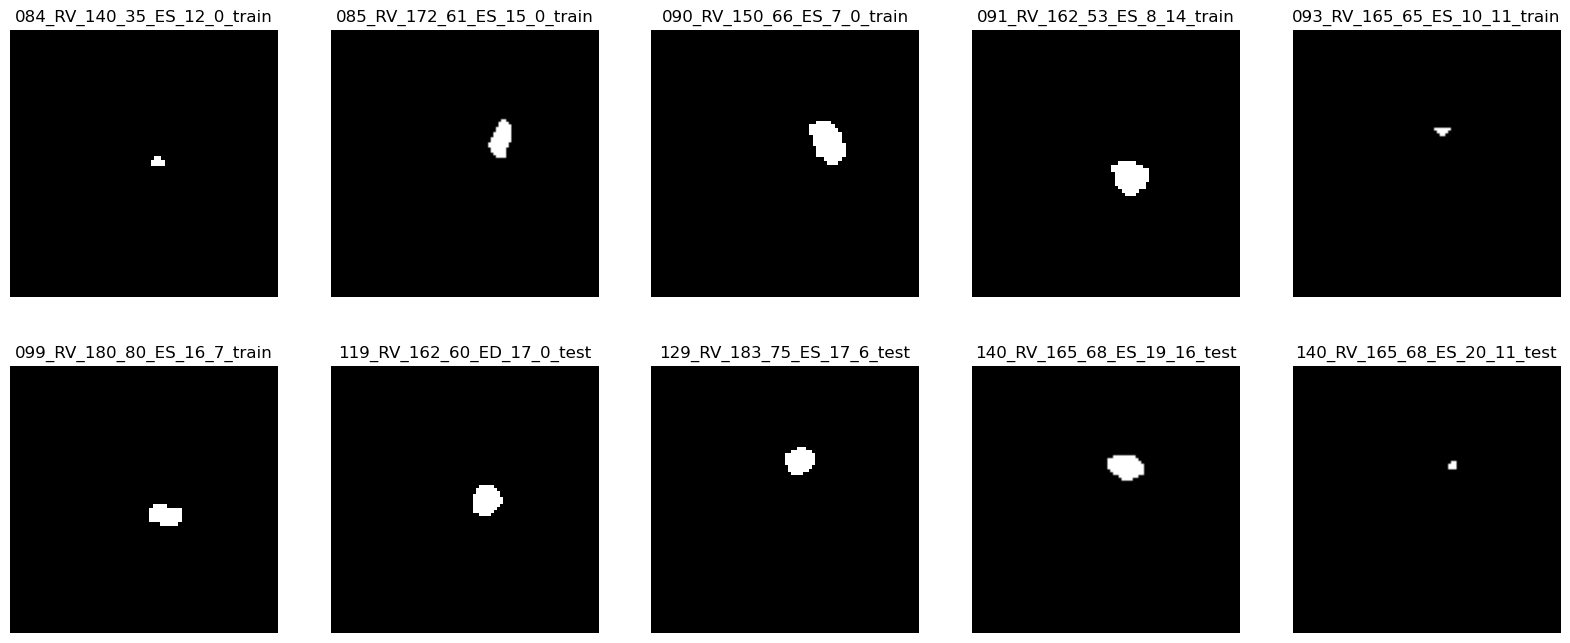

In [43]:
empty_mask = df['Empty slice']

non_empty_outliers = df[outliers_mask & ~empty_mask].index

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, idx in enumerate(non_empty_outliers):
    if idx < split:
        image = train_images[idx]
        name = '_'.join(train_labels[idx])
    else:
        image = test_images[idx - split]
        name = '_'.join(test_labels[idx - split])
    ax = axes.flat[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(name)
    ax.axis('off')

plt.savefig('pngs/non_empty_outliers.png')

In [35]:
non_empty_outliers

Index([1546, 1576, 1673, 1689, 1730, 1876, 2243, 2526, 2775, 2777], dtype='int64')

In [12]:
reducer_f = umap.UMAP()
embeddings_f = reducer.fit_transform(codes_f)

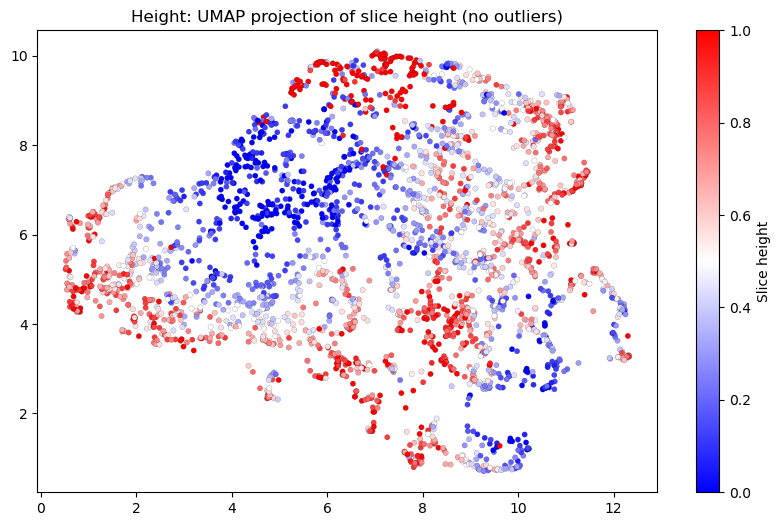

In [114]:
fig, ax = plt.subplots(figsize = (10, 6))

sc = ax.scatter(embeddings_f[:, 0], embeddings_f[:, 1], c=df_f['Slice height'], cmap='bwr', s=15, edgecolors='black', linewidths=0.1, alpha=1)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Slice height')

#ax.legend(handles=[sc], loc='upper right')

ax.set_title('Height: UMAP projection of slice height (no outliers)')
plt.savefig('pngs/umap_height_no.png')
plt.show()

In [21]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [22]:
# Credit: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [98]:
# Filtering only middle slices

height_mask = (df_f['Slice height'] >= 0.5) & (df_f['Slice height'] <= 0.7)

codes_m = codes_f[height_mask]
df_m = df_f[height_mask]

reducer_m = umap.UMAP()
embeddings_m = reducer.fit_transform(codes_m)

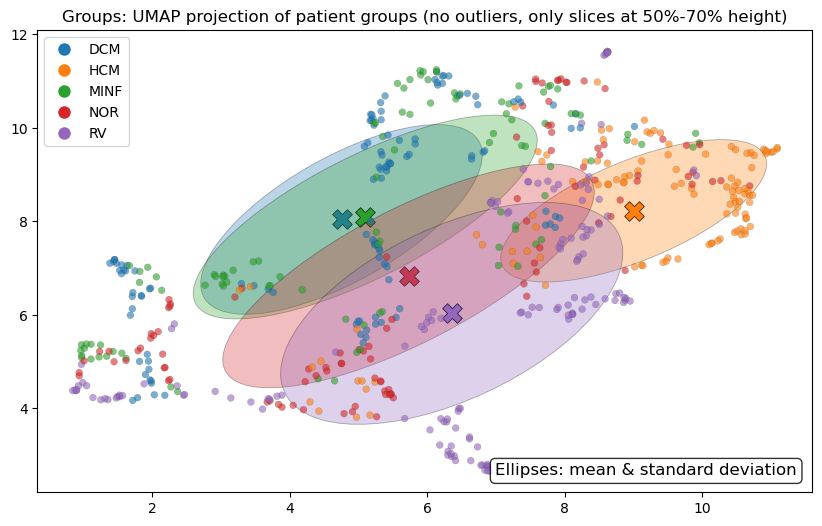

In [110]:
fig, ax = plt.subplots(figsize = (10, 6))

groups = np.unique(df_m['Group'])
tab10 = plt.get_cmap('tab10')
colors = {group: tab10(i) for i, group in enumerate(groups)}

for group in groups:
    mask = df_m['Group'] == group
    centroid = np.mean(embeddings_m[mask], axis=0)
    ax.scatter(centroid[0], centroid[1], c=[colors[group]], s=200, marker='X', edgecolors='black', linewidths=0.6)
    confidence_ellipse(embeddings_m[mask][:, 0], embeddings_m[mask][:, 1], ax, n_std=1.0, facecolor=colors[group], alpha=0.3, linewidth=0.6, edgecolor='black')

ax.scatter(embeddings_m[:, 0], embeddings_m[:, 1], c=df_m['Group'].map(colors), s=25, edgecolors='black', linewidths=0.1, alpha=0.6)


handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in tab10.colors[:len(groups)]]
ax.legend(handles, groups)

ax.set_title('Groups: UMAP projection of patient groups (no outliers, only slices at 50%-70% height)')

ax.text(0.98, 0.03, 'Ellipses: mean & standard deviation', 
        transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.8))

plt.savefig('pngs/umap_groups_no_m.png')
plt.show()

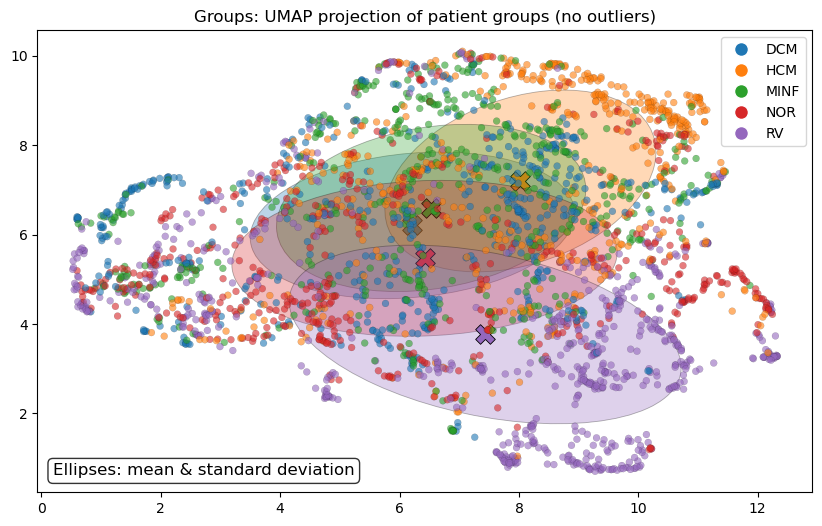

In [136]:
fig, ax = plt.subplots(figsize = (10, 6))

groups = np.unique(df_f['Group'])
tab10 = plt.get_cmap('tab10')
colors = {group: tab10(i) for i, group in enumerate(groups)}

for group in groups:
    mask = df_f['Group'] == group
    centroid = np.mean(embeddings_f[mask], axis=0)
    confidence_ellipse(embeddings_f[mask][:, 0], embeddings_f[mask][:, 1], ax, n_std=1.0, facecolor=colors[group], alpha=0.3, linewidth=0.6, edgecolor='black')
    ax.scatter(centroid[0], centroid[1], c=[colors[group]], s=200, marker='X', edgecolors='black', linewidths=0.6)

ax.scatter(embeddings_f[:, 0], embeddings_f[:, 1], c=df_f['Group'].map(colors), s=25, edgecolors='black', linewidths=0.1, alpha=0.6)


handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in tab10.colors[:len(groups)]]
ax.legend(handles, groups)

ax.text(0.02, 0.03, 'Ellipses: mean & standard deviation', 
        transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', 
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.8))

ax.set_title('Groups: UMAP projection of patient groups (no outliers)')
plt.savefig('pngs/umap_groups_no.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

groups = np.unique(df_f['Group'])
tab10 = plt.get_cmap('tab10')
colors = {group: tab10(i) for i, group in enumerate(groups)}

for group in groups:
    mask = df_f['Group'] == group
    centroid = np.mean(embeddings_f[mask], axis=0)
    ax.scatter(centroid[0], centroid[1], c=[colors[group]], s=200, marker='X', edgecolors='black', linewidths=0.6)
    confidence_ellipse(embeddings_f[mask][:, 0], embeddings_f[mask][:, 1], ax, n_std=1.0, facecolor=colors[group], alpha=0.3, linewidth=0.6, edgecolor='black')

ax.scatter(embeddings_f[:, 0], embeddings_f[:, 1], c=df_f['Group'].map(colors), s=25, edgecolors='black', linewidths=0.1, alpha=0.6)


handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in tab10.colors[:len(groups)]]
ax.legend(handles, groups)

ax.set_title('Groups: UMAP projection of patient groups (no outliers)')
#plt.savefig('pngs/umap_groups_no.png')
plt.show()

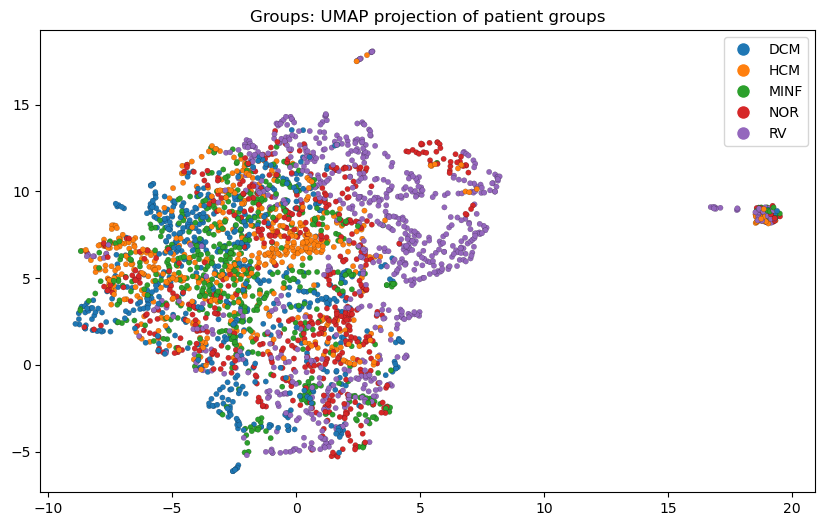

In [119]:
fig, ax = plt.subplots(figsize = (10, 6))

groups = np.unique(df['Group'])
tab10 = plt.get_cmap('tab10')
colors = {group: tab10(i) for i, group in enumerate(groups)}

ax.scatter(embeddings[:, 0], embeddings[:, 1], c=df['Group'].map(colors), s=15, edgecolors='black', linewidths=0.1, alpha=1)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in tab10.colors[:len(groups)]]
ax.legend(handles, groups)

ax.set_title('Groups: UMAP projection of patient groups')
#plt.savefig('pngs/umap_groups_wo.png')
plt.show()

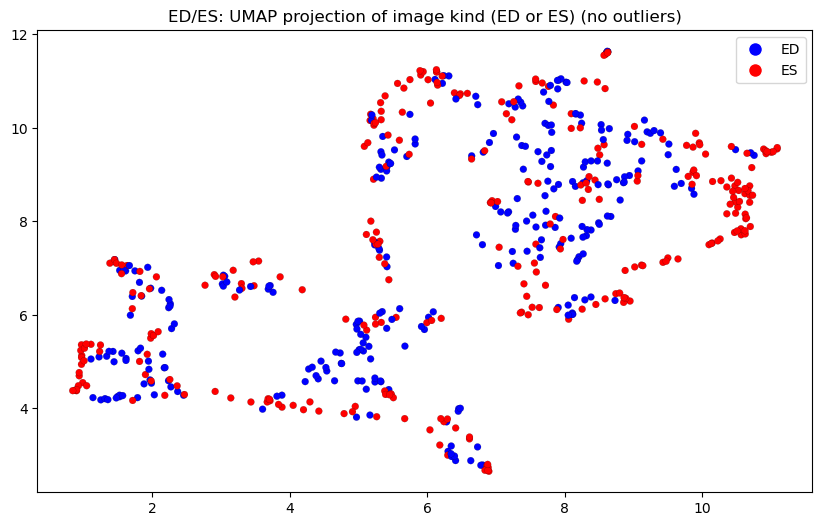

In [111]:
fig, ax = plt.subplots(figsize = (10, 6))

colors = {'ED': 'blue', 'ES': 'red'}

ax.scatter(embeddings_m[:, 0], embeddings_m[:, 1], c=df_m['ED/ES'].map(colors), s=25, edgecolors='black', linewidths=0.1, alpha=1)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in ['blue', 'red']]
ax.legend(handles, colors.keys())

ax.set_title('ED/ES: UMAP projection of image kind (ED or ES) (no outliers)')
#plt.savefig('pngs/umap_ed_es_no.png')
plt.show()

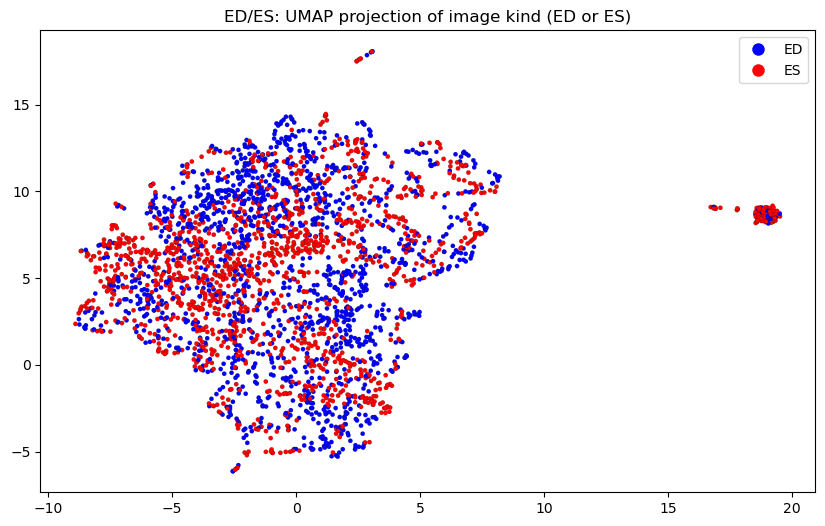

In [121]:
fig, ax = plt.subplots(figsize = (10, 6))

colors = {'ED': 'blue', 'ES': 'red'}

ax.scatter(embeddings[:, 0], embeddings[:, 1], c=df['ED/ES'].map(colors), s=10, edgecolors='black', linewidths=0.1, alpha=1)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in ['blue', 'red']]
ax.legend(handles, colors.keys())

ax.set_title('ED/ES: UMAP projection of image kind (ED or ES)')
#plt.savefig('pngs/umap_ed_es_wo.png')
plt.show()

In [129]:
patient_mask = df_f['Group'] == 'NOR'

codes_p = codes_f[patient_mask]
df_p = df_f[patient_mask]

reducer_p = umap.UMAP(n_neighbors=10)
embeddings_p = reducer_p.fit_transform(codes_p)


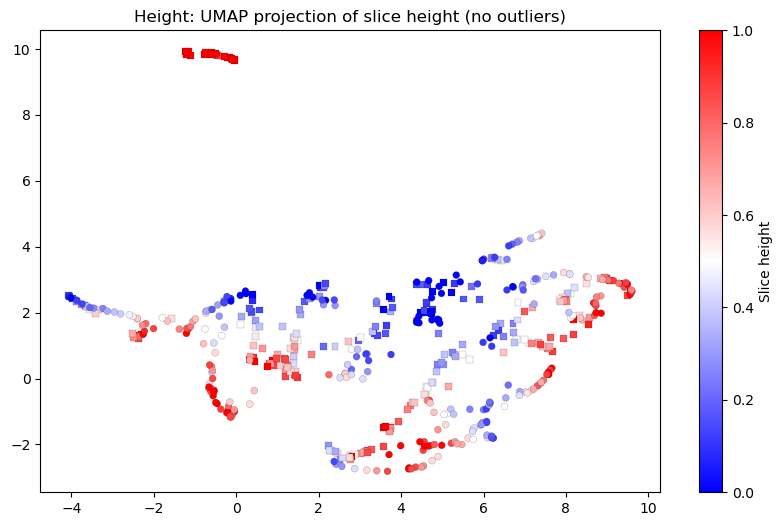

In [131]:
fig, ax = plt.subplots(figsize = (10, 6))

ed_mask = df_p['ED/ES'] == 'ED'

sc2 = ax.scatter(embeddings_p[~ed_mask][:, 0], embeddings_p[~ed_mask][:, 1], c=df_p[~ed_mask]['Slice height'], cmap='bwr', s=25, edgecolors='black', linewidths=0.1, alpha=1, marker='s')
sc = ax.scatter(embeddings_p[ed_mask][:, 0], embeddings_p[ed_mask][:, 1], c=df_p[ed_mask]['Slice height'], cmap='bwr', s=25, edgecolors='black', linewidths=0.1, alpha=1)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Slice height')

#ax.legend(handles=[sc], loc='upper right')

ax.set_title('Height: UMAP projection of slice height (no outliers)')
#plt.savefig('pngs/umap_height_no.png')
plt.show()

In [120]:
df_p

array([[-1.1477875e+00, -3.6789268e-01,  1.9902518e-01,  6.0498911e-01,
        -7.4527696e-02,  1.1716930e+00, -1.3780043e+00,  1.7037731e-01],
       [-1.4860690e+00, -1.7795589e+00, -2.3617928e-01,  9.0715605e-01,
        -4.0649912e-01,  1.2865585e+00,  1.8236805e-02, -9.8869002e-01],
       [-1.7534037e+00,  3.1991997e-01, -1.3177833e-01,  1.0019339e+00,
        -2.3301765e-01,  9.9256718e-01,  1.2250223e+00, -1.8188870e+00],
       [-1.5568548e+00,  3.2681620e-01,  3.5611928e-01,  3.6659881e-01,
        -1.4544584e-01,  1.1891204e+00,  1.3250601e+00, -1.2806281e+00],
       [-4.7382939e-01,  2.6020133e-01,  5.2415633e-01, -8.9438200e-01,
         4.3032899e-02,  1.5447025e+00,  9.7380865e-01, -1.4066340e+00],
       [-6.0193163e-01,  1.7233077e-01,  6.3746214e-01, -7.5191402e-01,
         4.1801819e-01,  1.7524451e+00,  8.9500749e-01, -1.2108294e+00],
       [-1.3175414e+00, -1.5306698e-01,  1.8391457e-01,  2.6630230e-02,
         8.5928053e-01,  1.3943150e+00,  7.2192448e-01, -1